# 2. Model selection and validation

In [0]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.4);
sns.set_style("whitegrid");

**Model selection and validation** are fundamental steps in statistical learning applications. In particular, we wish to compute (select) the model that performs optimally for **unseen external data** (data not seen during fitting the model parameters). For instance, when we augment the features in a data set by polynomial features of a certain degree $d$ we need to set $d$ such that it allows for fitting a model that performs best on all unseen external data. 
Parameters such as $d$ that needs to be set by the user are known as a **hyperparameters**.

Model selection is about the following considerations:

- when is a model a good model (e.g. what metric to use to validate the generalization performance of the model)?
- how to best pre-process the data (e.g. how to best normalize the data)?
- what to assume about the true model underlying the data (e.g linear/non-linear)?
- what are good values for the hyperparameters (this is known as **model tuning**)?

All these decisssions have to be made such that the resulting prediction model performs well on **unseen data**. 

The issue is of course that we don't have access yet to the unseen data. So we have to create it. We can estimate the expected performance on unseen data by splitting the data set into a data set for fitting (the **train set**) and a data set for testing the model (the **test set**). The process of fitting a model on a data set is also known as **training**.   

The testing data should **never** be used to make decission about what model to select.

Let's load a regression dataset:

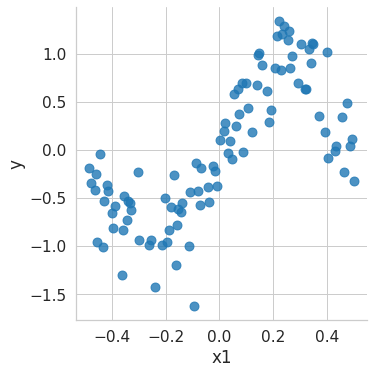

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/2_model_selection/dataset.csv")

sns.lmplot(x="x1", y="y", data=dataset, fit_reg=False, height=5.5, scatter_kws={"s": 80})
plt.show()

We randomly select 50% of the data set that we will treat as the unseen external data, known as the **(independent) test set**. The other 50% data points will be used for fitting (or **training**) a model and is known as the **train set**.

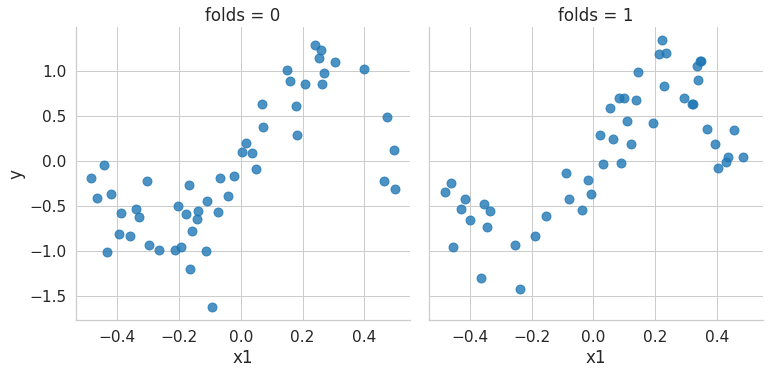

In [4]:
np.random.seed(1234)

dataset['folds'] = np.random.randint(2,size=len(dataset))

sns.lmplot(x="x1", y="y", col="folds", 
           data=dataset, fit_reg=False, height=5.5, scatter_kws={"s": 80})
plt.show()

Now we will augment the feature vectors with polynomial features of various degrees $d$ and fit a linear regression model to each train set. We evaluate the prediction performance on the corresponding test set: 

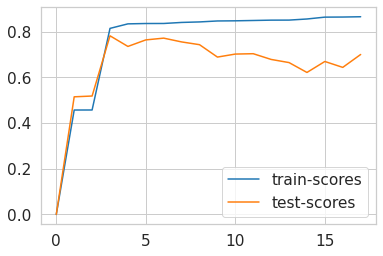

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
model = LinearRegression()

X = dataset.copy()
y = X.pop('y')
folds = X.pop('folds')

train_scores = [0] #no features (d=0)
test_scores = [0]

model.fit(X[folds!=1],y[folds!=1])
train_scores.append(model.score(X[folds!=1],y[folds!=1])) # d=1
test_scores.append(model.score(X[folds==1],y[folds==1]))

for degree in range(2,18,1):
    X['x1^'+str(degree)] = X['x1']**degree
    X['x1^'+str(degree)] = feature_scaler.fit_transform(X[ ['x1^'+str(degree)]])
    model.fit(X[folds!=1],y[folds!=1])
    train_scores.append(model.score(X[folds!=1],y[folds!=1]))
    test_scores.append(model.score(X[folds==1],y[folds==1]))

tmp = pd.DataFrame()
tmp['train-scores'] = train_scores
tmp['test-scores'] = test_scores
tmp.plot()
plt.show()

The blue curve shows how the accuracy on the train set increases with $d$ while the green curve shows how the accuracy on the test set starts to decrease for large values of $d$. Since both the train and test set are drawn randomly from the same data set we can conclude that $d>3$ allowed the linear regression algorithm to **fit the noise** in the augmented train set. We call this **overfitting**. For $d<3$ we can conclude that the model is not complex enough to fit the data set accurately. We call this **underfitting**.

It is not easy to avoid overfitting. For instance, to find the optimal value for $d$ we could train models with different values for $d$ on the train set and select the setting that performs best on the test set. We could then report the accuracy on this test set as an estimate of the performance of the model. However, in this case the test set would not represent true unseen external data as it is used to decide on the optimal value for $d$. As consequence the reported estimated generalization performance can be overly optimistic and not reflect the true expected generalization performance on the uneen external data.

To solve this problem, yet another part of the data set should be held out (known as the **validation set**). In this case a model is fitted on the train set and the optimal value for $d$ is selected using the validation set. A model is then trained on the union of the train and validation set using the best value for $d$ and the performance of this model is then tested on the test set to estimate the generalization performance. 

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for training and evaluating the model. Especially for smaller data sets this means that not only the fit of the model (train set) but also the decision on the values of the hyperparameters (validation set) as well as the estimation of the generalization performance (test set) will depend strongly on a particular random choice of the data set splits. 

To make our conclusions less dependent on the choice of the data split we can perform an approach called **cross-validation** (CV). In the basic setup, called **$k$-fold CV**, the data set is split into $k$ disjoint sets of approximately equal size. The following procedure is followed for each of the $k$ “folds” $D_i$ ($i=1 \ldots k$):

1. train a model $m_i$ on the data points in folds $D_j$ with $j \ne i$,
2. use $m_i$ to compute predictions for $D_i.$

As you can see we now have one prediction for each data point such that the model that computed that prediction was not trained on a train set that contained that data point. The performance measure reported by k-fold cross-validation is computed using these predictions and constitutes a good estimate for the generalization performance of the model. At the same time by choosing larger values for $k$ (typical value is 10) the size of the train set becomes larger and better models can be fitted, while still computing one prediction for each data point. 

Let's look at an implementation of the cross-validation loop:

In [6]:
def my_cross_val_predict(model,X,y,cv=5):
    predictions = np.empty(len(y))
    folds = np.random.randint(0,cv,size=len(y))
    for i in range(cv):
        Xtest = X[folds==i]
        ytest = y[folds==i]
        Xtrain = X[folds!=i]
        ytrain = y[folds!=i]
        model.fit(Xtrain,ytrain)
        p = model.predict(Xtest)
        counter = 0
        for j in range(len(folds)):
            if folds[j] == i:
                predictions[j] = p[counter]
                counter += 1            
    return predictions
        
X = dataset[dataset['folds']==0].copy()
y = X.pop('y')    
folds = X.pop('folds')

cv_predictions = my_cross_val_predict(model,X,y,cv=5)

print(cv_predictions)

[-0.87043807 -0.59124865 -0.24619693  0.25542288  0.17247272 -0.76810345
 -0.39969885  0.03145744  0.32923122 -0.8011339   0.72823881  0.33756766
 -0.25643039 -0.22097393  0.27709494 -0.67114179 -0.27545816 -0.44605786
  0.33007803  0.13749306 -0.63214386  0.66268889  0.55431515 -0.01082733
  0.18751171  0.33837304  1.05345264  0.48409826 -0.18479617  0.00410999
 -0.36670334  0.28754901 -0.17929172 -0.39048885 -0.91137191 -0.37102988
 -0.69162855 -0.01001764 -0.1627871  -0.15409578 -0.36311251 -0.50203346
  0.02696594 -0.78379704 -0.75786999 -0.00753461  0.04033998 -0.91289859
 -0.55091831 -0.37936633  0.77735295]


We can now compute an estimate of the generalization performance of the model using these predictions:

In [7]:
from sklearn import metrics

print(metrics.r2_score(y,cv_predictions))

0.3968355011488862


In scikit-learn we can use the `cross_val_predict()` function in the module `sklearn.cross_validation` to do the same thing:

In [8]:
from sklearn.model_selection import cross_val_predict

cv_predictions = cross_val_predict(model,X,y,cv=5)
print(cv_predictions)

[-0.94689643 -0.67405743 -0.35249718  0.31985608  0.22241358 -0.84945393
 -0.49866093  0.05676133  0.42704283 -0.89817518  0.87527833  0.35998747
 -0.30469029 -0.18310289  0.22218842 -0.62081751 -0.25605533 -0.4019602
  0.33566999  0.16544764 -0.60460586  0.86251173  0.73623463 -0.07970966
  0.30883524  0.4642532   0.93050709  0.55167581 -0.24484124  0.09513555
 -0.36140471  0.40868214 -0.06180893 -0.31385772 -0.76754554 -0.25504634
 -0.59111139  0.08942034 -0.11221869 -0.1458252  -0.28865284 -0.50281178
  0.04857461 -0.81526406 -0.73255611  0.01181552 -0.0157538  -0.9071618
 -0.56714019 -0.31901631  0.84808487]


In [9]:
print(metrics.r2_score(y,cv_predictions))

0.41220785506230706


To optimize the degree $d$ we can now use the CV loop:

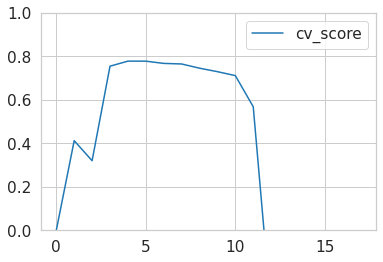

best CV score: 0.77796101768555
optimal degree d: 4


In [10]:
X = dataset[dataset['folds']==0].copy()
y = X.pop('y')
folds = X.pop('folds')

scores = []
scores.append(0) # no features (d=0)
cv_predictions = cross_val_predict(model, X, y, cv=5) # (d=1)
scores.append(metrics.r2_score(y,cv_predictions)) 
for degree in range(2,18,1):
    X['x1^'+str(degree)] = X['x1']**degree
    X['x1^'+str(degree)] = feature_scaler.fit_transform(X[ ['x1^'+str(degree)]])
    cv_predictions = cross_val_predict(model, X, y, cv=5) # (d=1)
    scores.append(metrics.r2_score(y,cv_predictions)) 

tmp = pd.DataFrame(scores,columns=['cv_score'])
tmp.plot(ylim=(0,1))
plt.show()
print("best CV score: {}".format(max(scores)))
print("optimal degree d: {}".format(np.argmax(scores)))

Should we consider this best CV score a good estimated of the generalization performance of a model with optimal degree $d$? No. The CV predictions were used to make the decision on the optimal degree $d$. Instead we need a second CV loop that is nested in the first loop to estimate the generalization performance while minimizing the possibility of overfitting. This is called **nested-CV** and will be explained further in this course.